# Testing K nearest neigbours

Using the features file to separate into labels and features

In [23]:
import pandas as pd
import numpy as np

data = pd.read_csv('./util/feature_dataset.csv') 
data.fillna(0, inplace=True)
X = data[['border', 'asymmetry', 'mean_H', 'std_H', 'mean_S', 'std_S', 'mean_V', 'std_V']]

data['cancer'] = data['cancer'].astype(int)
y = data['cancer']
groups = data['patient_id']
unique_patients = data['patient_id'].unique()

Running cross-validation over different k values (get AUC)

In [24]:
from sklearn.model_selection import train_test_split, GroupKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

#split data into training and test sets (by patient ID)
unique_patients = data['patient_id'].unique()
train_ids, test_ids = train_test_split(unique_patients, test_size=0.2, random_state=42)
train_idx = data['patient_id'].isin(train_ids)

X_train, y_train = X[train_idx], y[train_idx]
groups_train = groups[train_idx]

#standardScaler on training data (within pipeline below)
#GroupKFold CV with k from 3 to 10
cv = GroupKFold(n_splits=5)
k_values = range(1, 101, 2)
summary = []

for k in k_values:
    pipe = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k))
    auc_scores = cross_val_score(pipe, X_train, y_train, cv=cv, groups=groups_train, scoring='roc_auc')
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    print(f"k={k}, AUC={mean_auc:.4f} ± {std_auc:.4f}")
    summary.append({'k': k, 'mean_auc': mean_auc, 'std_auc': std_auc})

summary_df = pd.DataFrame(summary)

k=1, AUC=0.5962 ± 0.0258
k=3, AUC=0.6368 ± 0.0293
k=5, AUC=0.6582 ± 0.0163
k=7, AUC=0.6597 ± 0.0185
k=9, AUC=0.6592 ± 0.0240
k=11, AUC=0.6639 ± 0.0211
k=13, AUC=0.6740 ± 0.0268
k=15, AUC=0.6817 ± 0.0275
k=17, AUC=0.6833 ± 0.0311
k=19, AUC=0.6862 ± 0.0241
k=21, AUC=0.6903 ± 0.0206
k=23, AUC=0.6923 ± 0.0208
k=25, AUC=0.6961 ± 0.0257
k=27, AUC=0.7039 ± 0.0223
k=29, AUC=0.7030 ± 0.0243
k=31, AUC=0.7050 ± 0.0225
k=33, AUC=0.7053 ± 0.0217
k=35, AUC=0.7052 ± 0.0262
k=37, AUC=0.7038 ± 0.0281
k=39, AUC=0.7026 ± 0.0267
k=41, AUC=0.6991 ± 0.0260
k=43, AUC=0.7008 ± 0.0250
k=45, AUC=0.7035 ± 0.0259
k=47, AUC=0.7038 ± 0.0267
k=49, AUC=0.7030 ± 0.0264
k=51, AUC=0.7027 ± 0.0263
k=53, AUC=0.7021 ± 0.0264
k=55, AUC=0.7019 ± 0.0264
k=57, AUC=0.7030 ± 0.0263
k=59, AUC=0.7022 ± 0.0275
k=61, AUC=0.7039 ± 0.0278
k=63, AUC=0.7051 ± 0.0279
k=65, AUC=0.7025 ± 0.0265
k=67, AUC=0.7009 ± 0.0272
k=69, AUC=0.7013 ± 0.0266
k=71, AUC=0.6998 ± 0.0275
k=73, AUC=0.6996 ± 0.0268
k=75, AUC=0.7003 ± 0.0265
k=77, AUC=0.6999 

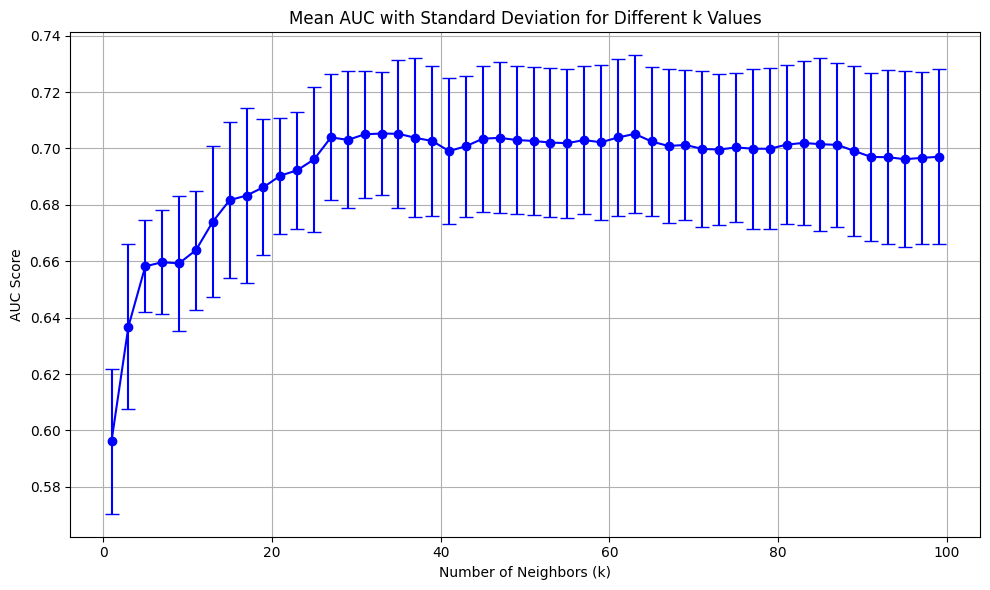

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
plt.errorbar(summary_df['k'], summary_df['mean_auc'], yerr=summary_df['std_auc'], 
             fmt='-o', capsize=5, color='blue')
plt.title('Mean AUC with Standard Deviation for Different k Values')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('AUC Score')
plt.grid(True)
plt.tight_layout()
plt.show()

Chosing k=25 to train the model

In [26]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GroupKFold, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix
import pandas as pd
import numpy as np

# Create test mask similar to train mask
test_mask = data['patient_id'].isin(test_ids)

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_mask], y[test_mask]
groups_train = groups[train_idx]
patient_ids_test = groups[test_mask]

# Fit final model on training data (best k = 25)
pipe = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=25))
pipe.fit(X_train, y_train)

# Predict on test set
y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]  # Probability of cancer

# Metrics
acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
cm = confusion_matrix(y_test, y_pred)

print("Final Evaluation on Test Set:")
print(f"Accuracy: {acc:.4f}")
print(f"Recall: {rec:.4f}")
print(f"AUC: {auc:.4f}")
print("Confusion Matrix:")
print(cm)

results_df = pd.DataFrame({
    "patient_id": patient_ids_test.values,
    "true_label": y_test.values,
    "cancer_probability": y_prob
})
# results_df.to_csv("knn_final_test_probs.csv", index=False)

Final Evaluation on Test Set:
Accuracy: 0.6179
Recall: 0.5753
AUC: 0.7001
Confusion Matrix:
[[89 45]
 [62 84]]


Checking features

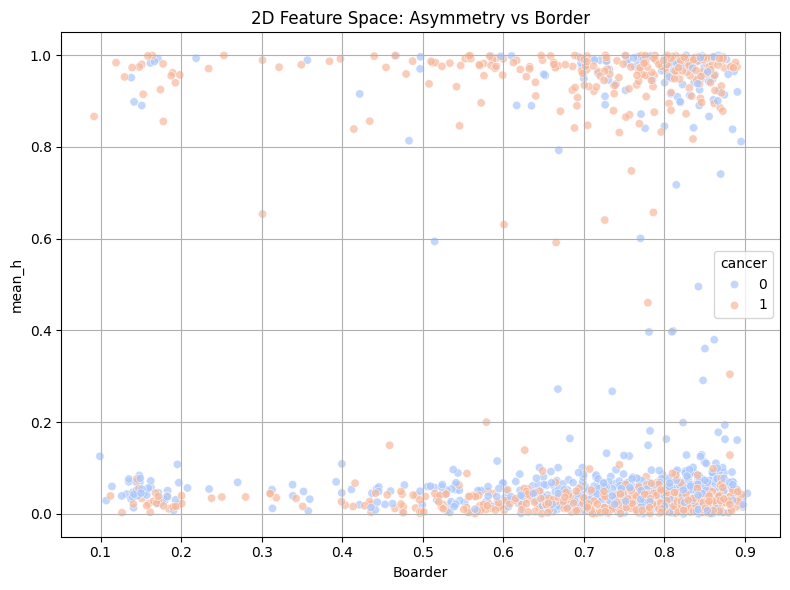

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=data, 
    x='border', 
    y='mean_H', 
    hue='cancer', 
    palette='coolwarm', 
    alpha=0.7
)
plt.title("2D Feature Space: Asymmetry vs Border")
plt.xlabel("Boarder")
plt.ylabel("mean_h")
plt.grid(True)
plt.tight_layout()
plt.show()


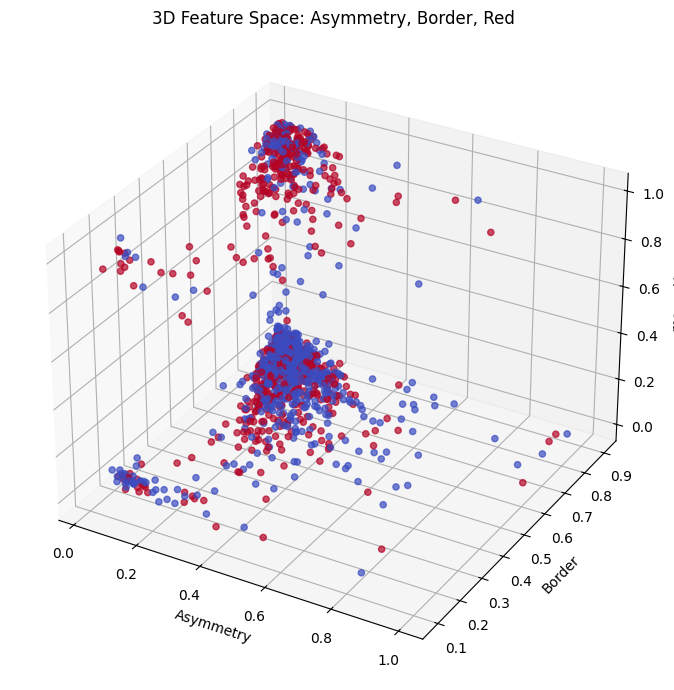

In [28]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot
ax.scatter(
    data['asymmetry'], 
    data['border'], 
    data['mean_H'], 
    c=data['cancer'], 
    cmap='coolwarm', 
    alpha=0.7
)

ax.set_title("3D Feature Space: Asymmetry, Border, Red")
ax.set_xlabel("Asymmetry")
ax.set_ylabel("Border")
ax.set_zlabel("mean_H")
plt.tight_layout()
plt.show()

## Patient Distribution

Total number of unique patients: 911
Average images per patient: 1.54
Max images per patient: 9
Min images per patient: 1


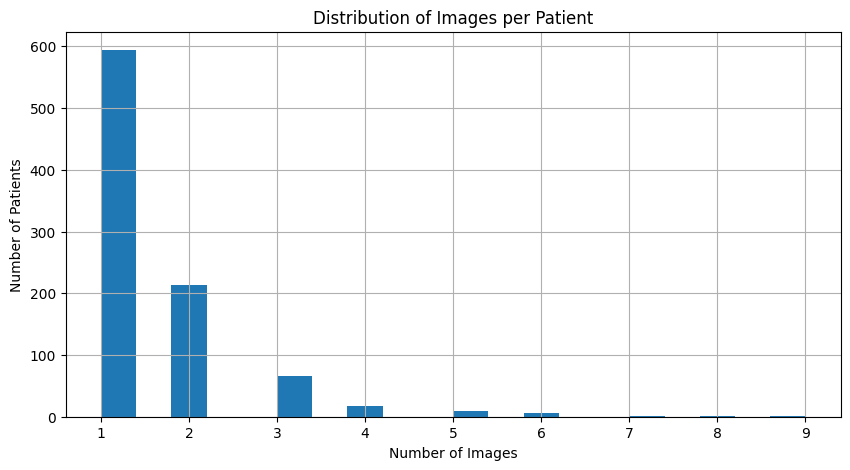

In [29]:
# Analyze patient distribution
patient_counts = data['patient_id'].value_counts()

print(f"Total number of unique patients: {len(patient_counts)}")
print(f"Average images per patient: {patient_counts.mean():.2f}")
print(f"Max images per patient: {patient_counts.max()}")
print(f"Min images per patient: {patient_counts.min()}")

# Show distribution of number of images per patient
plt.figure(figsize=(10, 5))
patient_counts.hist(bins=20)
plt.title('Distribution of Images per Patient')
plt.xlabel('Number of Images')
plt.ylabel('Number of Patients')
plt.show()

## Train-Test Split
function for keeping all images from a patient in one group

In [30]:
from sklearn.model_selection import train_test_split

# First, let's verify our split maintains patient separation
def verify_patient_split(train_ids, test_ids):
    intersection = set(train_ids) & set(test_ids)
    if len(intersection) > 0:
        print(f"Warning: {len(intersection)} patients appear in both sets!")
        return False
    return True

# Split patients into train and test sets
unique_patients = data['patient_id'].unique()
train_ids, test_ids = train_test_split(unique_patients, test_size=0.2, random_state=42)

# Verify the split
is_valid_split = verify_patient_split(train_ids, test_ids)
print(f"Split is valid: {is_valid_split}")

# Create train and test masks
train_mask = data['patient_id'].isin(train_ids)
test_mask = data['patient_id'].isin(test_ids)

# Print split statistics
print(f"\nTraining set:")
print(f"Number of patients: {len(train_ids)}")
print(f"Number of images: {train_mask.sum()}")

print(f"\nTest set:")
print(f"Number of patients: {len(test_ids)}")
print(f"Number of images: {test_mask.sum()}")

# Create the actual split datasets
X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]
groups_train = groups[train_mask]

Split is valid: True

Training set:
Number of patients: 728
Number of images: 1122

Test set:
Number of patients: 183
Number of images: 280
